In [9]:
import csv
import json
from pathlib import Path
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pedpy
import plotly.graph_objects as go
import shapely
from jupedsim.internal.notebook_utils import animate
from shapely import from_wkt
import math

print(f"PedPy version: {pedpy.__version__}")

PedPy version: 1.2.0


Agents: 85
../trajectories_croma/1C070_cam6_cam5_frameshift0_Combined.txt
frame_after_decrease = 5016
Data written to ../trajectories_croma/1C070_frame_5016.csv
num_frames = 0 5016 5016


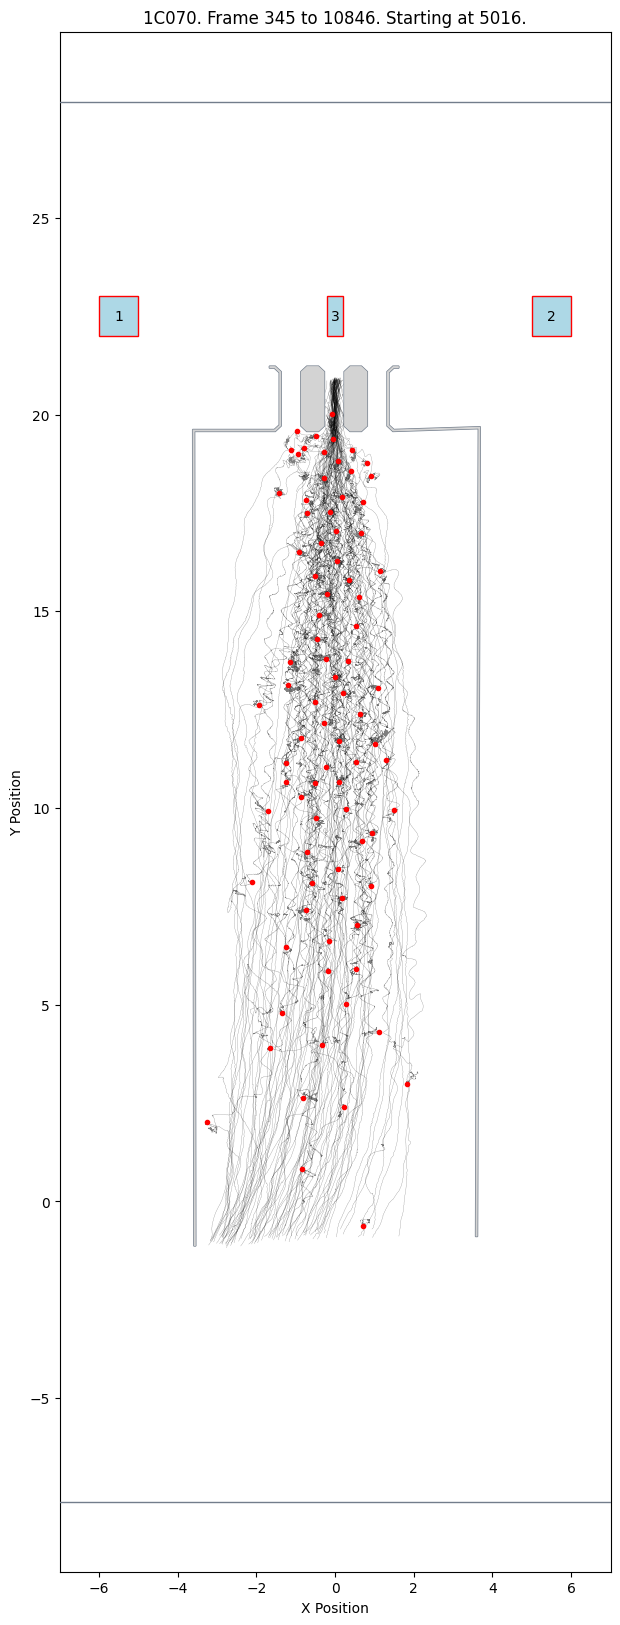

Agents: 89
../trajectories_croma/2C070_cam6_cam5_frameshift0_Combined.txt
frame_after_decrease = 4520
Data written to ../trajectories_croma/2C070_frame_4520.csv
num_frames = 0 4520 4520


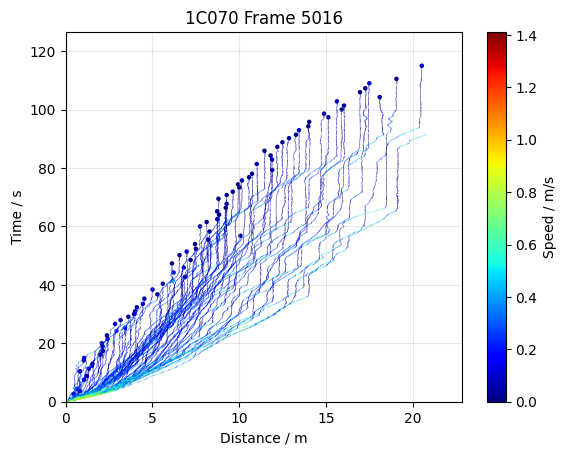

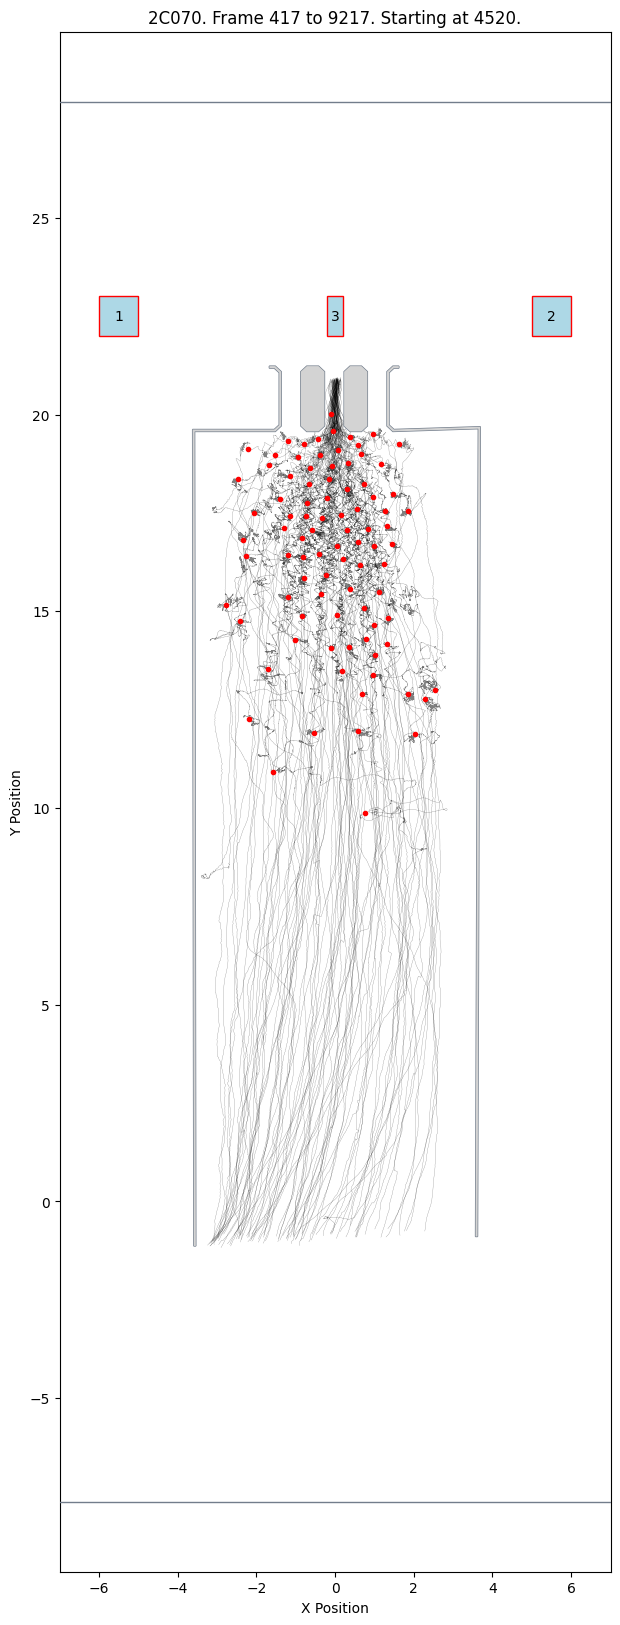

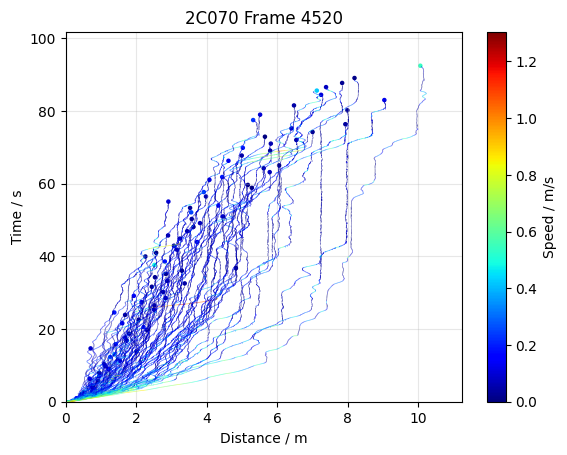

In [10]:
# Define the WKT string for the polygon
geometry = from_wkt(
    "POLYGON ((-8.88 -7.63, 8.3 -7.63, 8.3 27.95, -8.88 27.95, -8.88 -7.63), (-3.54 -1.13, -3.57 19.57, -1.52 19.57, -1.37 19.71, -1.37 21.09, -1.52 21.23, -1.67 21.23, -1.67 21.18, -1.545 21.18, -1.4200000000000002 21.065, -1.4200000000000002 19.735, -1.545 19.62, -3.6199999999999997 19.62, -3.59 -1.13, -3.54 -1.13), (3.57 -0.89, 3.64 19.64, 1.47 19.57, 1.32 19.71, 1.32 21.09, 1.47 21.23, 1.62 21.23, 1.62 21.18, 1.4949999999999999 21.18, 1.37 21.065, 1.37 19.735, 1.4949999999999999 19.62, 3.69 19.69, 3.6199999999999997 -0.89, 3.57 -0.89), (0.67 19.57, 0.82 19.71, 0.82 21.09, 0.67 21.23, 0.38 21.23, 0.23 21.09, 0.23 19.71, 0.38 19.57, 0.67 19.57), (-0.42 19.57, -0.27 19.71, -0.27 21.09, -0.42 21.23, -0.72 21.23, -0.87 21.09, -0.87 19.71, -0.72 19.57, -0.42 19.57))"
)
filenames = [
    #"../trajectories_croma/1C060_cam6_cam5_frameshift0_Combined.txt", # low motivation
    "../trajectories_croma/1C070_cam6_cam5_frameshift0_Combined.txt", # low motivation
    "../trajectories_croma/2C070_cam6_cam5_frameshift0_Combined.txt",  # high motivation
    #"../trajectories_croma/2C120_cam6_cam5_frameshift0_Combined.txt",  # high motivation
    #"../trajectories_croma/2C130_cam6_cam5_frameshift0_Combined.txt", # low motivation
    #"../trajectories_croma/2C150_cam6_cam5_frameshift0_Combined.txt", # low motivation
]


def read_json_file(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


def get_first_frame_pedestrian_passes_line(filename: str, passing_line_y: float = 20):
    """
    Return the first frame when a pedestrian passes the specified horizontal line.
    Also return the DataFrame of whole trajectories.
    60 -> 19.71
    70 ->
    """
    df = pd.read_csv(
        filename, sep="\t", names=["id", "frame", "x", "y", "z", "m"], comment="#"
    )
    df = df.sort_values(["frame", "id"])
    df["y_diff"] = df.groupby("id")["y"].diff()
    crossing_frame = df[(df["y"] >= passing_line_y) & (df["y_diff"] > 0)]["frame"].min()
    if pd.isna(crossing_frame):
        return df, None
    else:
        return df, int(crossing_frame)


def plot_trajectories_around_frame(
    df: pd.DataFrame,
    target_frame: int,
    num_frames: int = 10,
    title: str = "",
    geometry: Optional[shapely.Geometry] = None,
    inifile: str = "files/inifile.json",
    plot_all_pedestrians: bool = False,
) -> None:
    """Plot trajectories for num_frames before and after the target frame."""
    fig, axes = create_figure()

    plot_pedestrian_trajectories(
        df,
        target_frame,
        plot_all_pedestrians=plot_all_pedestrians,
        num_frames=num_frames,
    )
    plot_walkable_area(geometry)
    plot_doors_and_destinations(inifile)
    set_plot_properties(title)
    plt.savefig(f"files/figures/{title}.pdf")
    plt.show()


def filter_dataframe(
    df: pd.DataFrame, target_frame: int, num_frames: int
) -> pd.DataFrame:
    """
    Filter the dataframe to include only the frames around the target frame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing trajectory data.
    target_frame (int): The frame number to center the filter around.
    num_frames (int): The number of frames to include before and after the target frame.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the frames within the specified range.
    """
    start_frame = max(target_frame - num_frames, df["frame"].min())
    end_frame = min(target_frame + num_frames, df["frame"].max())
    return df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]


def create_figure(num_rows=1, num_cols=1, fig_width=20, fig_height=20):
    """Create and return a figure and axes for plotting."""
    return plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


def plot_pedestrian_trajectories(
    df: pd.DataFrame,
    target_frame: int,
    num_frames=10,
    plot_all_pedestrians: bool = False,
):
    """Plot the trajectories of all pedestrians in the filtered dataframe."""
    start_frame = max(target_frame - num_frames, df["frame"].min())
    end_frame = min(target_frame + num_frames, df["frame"].max())
    print(f"{num_frames = }", start_frame, end_frame)
    filtered_df = df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]
    ids = np.unique(filtered_df["id"])
    for ped in ids:
        ped_data = df[df["id"] == ped]
        for frame in range(start_frame, end_frame + 1):
            color = "red" if frame == target_frame else "gray"
            # color = "red" if ped == 11 else "gray"
            zorder = 10 if frame == target_frame else 1
            frame_data = ped_data[
                (ped_data["frame"] == frame)
            ]  # & (ped_data['y']>18.7) & (ped_data['id'].isin([13,11]))]
            if not frame_data.empty:
                plt.plot(
                    frame_data["x"],
                    frame_data["y"],
                    ".-",
                    zorder=zorder,
                    color=color,
                    # label=f"Ped {ped} at frame {frame}",
                    # label=f"{ped}",
                )

        if plot_all_pedestrians:
            plt.plot(
                ped_data["x"],
                ped_data["y"],
                label=f"Ped {ped}",
                color="black",
                alpha=0.5,
                lw=0.2,
            )


def plot_walkable_area(geometry: shapely.Geometry, axes: Optional[plt.Axes] = None):
    """Plot the walkable area defined by the given geometry."""

    walkable_area = pedpy.WalkableArea(geometry)
    pedpy.plot_walkable_area(walkable_area=walkable_area, axes=axes)


def plot_doors_and_destinations(inifile: str):
    """Plot doors and destinations from the inifile."""
    data = read_json_file(inifile)
    # plot_doors(data)
    plot_destinations(data)


def plot_time_distance(measurement_line, traj, title):
    speed = pedpy.compute_individual_speed(traj_data=traj, frame_step=5)

    df_time_distance = pedpy.compute_time_distance_line(
        traj_data=traj, measurement_line=measurement_line
    )
    pedpy.plot_time_distance(
        time_distance=df_time_distance,
        frame_rate=traj.frame_rate,
        speed=speed,
        title=title,
    )


def plot_doors(data: dict):
    """Plot doors from the inifile data."""
    motivation_doors = data["motivation_parameters"]["motivation_doors"]
    width = data["motivation_parameters"]["width"]
    for door in motivation_doors:
        vertices = door["vertices"]
        x_vals, y_vals = zip(*vertices)
        plt.plot(x_vals, y_vals, label=f"Door {door['id']}", color="red", lw=2)
        center_x, center_y = np.mean(x_vals), np.mean(y_vals)
        plt.plot(center_x, center_y, marker="o", color="b")
        circle = plt.Circle(
            (center_x, center_y), width, color="b", alpha=0.3, fill=True
        )
        plt.gca().add_artist(circle)


def plot_destinations(data: dict):
    """Plot destinations from the inifile data."""
    for destination in data["destinations"]:
        vertices = destination["vertices"]
        polygon = plt.Polygon(
            vertices,
            closed=True,
            fill=True,
            edgecolor="r",
            facecolor="lightblue",
            label=f"Exit {destination['id']}",
        )
        plt.gca().add_patch(polygon)
        centroid = [sum(x) / len(vertices) for x in zip(*vertices)]
        plt.text(
            centroid[0],
            centroid[1],
            f"{destination['id']}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )


def set_plot_properties(title: str):
    """Set the properties of the plot."""
    plt.xlim(-7, 7)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"{title}.")
    plt.gca().set_aspect("equal")
    # plt.legend()


def print_agent_info(
    df: pd.DataFrame, filename: str, frame_after_decrease: Optional[int]
) -> None:
    """Print information about the number of agents and the frame after the decrease."""
    print(f"Agents: {len(df['id'].unique())}")
    print(f"{filename}")
    print(f"{frame_after_decrease = }")


def extract_title(filename: str) -> str:
    """Extract the title from the filename (before the first underscore)."""
    return Path(filename).stem.split("_")[0]


def write_frame_data_to_file(
    df: pd.DataFrame, frame_after_decrease: int, filename: str
) -> None:
    """Write the frame data to a CSV file."""
    frame_data: pd.DataFrame = df[df["frame"] == frame_after_decrease]
    tuple_list: List[Tuple[float, float]] = [
        tuple(x) for x in frame_data[["x", "y"]].to_numpy()
    ]
    title: str = extract_title(filename)
    output_filename: str = (
        f"../trajectories_croma/{title}_frame_{frame_after_decrease}.csv"
    )

    with open(output_filename, "w") as f:
        writer: csv.writer = csv.writer(f)
        writer.writerows(tuple_list)
    print(f"Data written to {output_filename}")


def process_file(filename: str, geometry: shapely.geometry.Polygon) -> None:
    """Process the file and handle data extraction, plotting, and file output."""
    df: pd.DataFrame
    frame_after_decrease: Optional[int]
    df, frame_after_decrease = get_first_frame_pedestrian_passes_line(filename)
    print_agent_info(df, filename, frame_after_decrease)
    df_moving = df[df["frame"] >= frame_after_decrease]
    traj_moving = pedpy.TrajectoryData(df_moving, frame_rate=50)
    inifile = "files/inifile.json"
    data = read_json_file(inifile)
    measurement_line = pedpy.MeasurementLine(data["measurement_line"]["vertices"])

    if frame_after_decrease is not None:
        write_frame_data_to_file(df, frame_after_decrease, filename)
        title = extract_title(filename)
        start_frame, end_frame = df["frame"].min(), df["frame"].max()
        title = f"{title}. Frame {start_frame} to {end_frame}. Starting at {frame_after_decrease}"
        plot_trajectories_around_frame(
            df,
            frame_after_decrease,
            num_frames=0,
            title=title,
            geometry=geometry,
            plot_all_pedestrians=True,
        )
        title = extract_title(filename) + f" Frame {frame_after_decrease}"
        plot_time_distance(measurement_line, traj_moving, title)
    else:
        print("No valid frame found for visualization.")


def process_files(filenames: List[str], geometry: shapely.geometry.Polygon) -> None:
    """Process a list of filenames."""
    for filename in filenames:
        process_file(filename, geometry)


process_files(filenames, geometry)

## Plot geometry for debugging coordinates

In [11]:
# Parse the WKT polygon
geometry2 = from_wkt(
    "POLYGON ((-8.88 -7.63, 8.3 -7.63, 8.3 27.95, -8.88 27.95, -8.88 -7.63), (-3.54 -1.13, -3.57 19.57, -1.52 19.57, -1.37 19.71,  -0.87 19.71, -0.72 19.57, -0.42 19.57, -0.27 19.71, -0.27 21.09, -0.42 21.23, -0.72 21.23, -0.87 21.09, -1.37 21.09, -1.52 21.23, -1.67 21.23, -1.67 21.18, -1.545 21.18, -1.4200000000000002 21.065, -1.4200000000000002 19.735, -1.545 19.62, -3.6199999999999997 19.62, -3.59 -1.13, -3.54 -1.13), (3.57 -0.89, 3.64 19.64, 1.47 19.57, 1.32 19.71, 0.82 19.71, 0.67 19.57, 0.38 19.57, 0.23 19.71, 0.23 21.09, 0.38 21.23, 0.67 21.23, 0.82 21.09, 1.32 21.09, 1.47 21.23, 1.62 21.23, 1.62 21.18, 1.4949999999999999 21.18, 1.37 21.065, 1.37 19.735, 1.4949999999999999 19.62, 3.69 19.69, 3.6199999999999997 -0.89, 3.57 -0.89))"
)


# Extract exterior coordinates
exterior_x, exterior_y = geometry2.exterior.xy

# Extract interior coordinates (holes)
interiors = [list(interior.coords.xy) for interior in geometry2.interiors]
exterior_x = list(geometry2.exterior.xy[0])
exterior_y = list(geometry2.exterior.xy[1])

# Extract interior coordinates (holes) as lists
interiors = [
    (list(interior.xy[0]), list(interior.xy[1])) for interior in geometry2.interiors
]

# Create the figure
fig = go.Figure()

# Plot exterior
fig.add_trace(go.Scatter(x=exterior_x, y=exterior_y, mode="lines", name="Exterior"))

# Plot interiors (holes)
for i, (x, y) in enumerate(interiors):
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name=f"Interior {i+1}"))
    print(f"Interior {i+1}. {x = }, {y = }")


# fig.add_trace(go.Scatter(x=combined_x, y=combined_y, mode='lines+markers', fill='toself', name='Combined Polygon'))

# Update layout
fig.update_layout(
    title="Polygon with Interior Holes",
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate",
    showlegend=True,
    width=600,
    height=600,
)

Interior 1. x = [-3.54, -3.57, -1.52, -1.37, -0.87, -0.72, -0.42, -0.27, -0.27, -0.42, -0.72, -0.87, -1.37, -1.52, -1.67, -1.67, -1.545, -1.4200000000000002, -1.4200000000000002, -1.545, -3.6199999999999997, -3.59, -3.54], y = [-1.13, 19.57, 19.57, 19.71, 19.71, 19.57, 19.57, 19.71, 21.09, 21.23, 21.23, 21.09, 21.09, 21.23, 21.23, 21.18, 21.18, 21.065, 19.735, 19.62, 19.62, -1.13, -1.13]
Interior 2. x = [3.57, 3.64, 1.47, 1.32, 0.82, 0.67, 0.38, 0.23, 0.23, 0.38, 0.67, 0.82, 1.32, 1.47, 1.62, 1.62, 1.4949999999999999, 1.37, 1.37, 1.4949999999999999, 3.69, 3.6199999999999997, 3.57], y = [-0.89, 19.64, 19.57, 19.71, 19.71, 19.57, 19.57, 19.71, 21.09, 21.23, 21.23, 21.09, 21.09, 21.23, 21.23, 21.18, 21.18, 21.065, 19.735, 19.62, 19.69, -0.89, -0.89]


## Plot motivation heatmaps

In [12]:
motiv_files = ['files/trajectory_variation_001_motivation.csv',
               #'files/trajectory_variation_002_motivation.csv',
               #'files/trajectory_variation_003_motivation.csv',
               #'files/trajectory_variation_004_motivation.csv',
               #'files/trajectory_variation_005_motivation.csv',
               #'files/trajectory_variation_006_motivation.csv',
               #'files/trajectory_variation_007_motivation.csv',
]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'yellow']

for i, motiv_file in enumerate(motiv_files):
    df = pd.read_csv(motiv_file,  names=["frame", "id", "time", "motivation", "x", "y", "value"])
    for id_to_plot in df["id"].unique():
        if id_to_plot!= 61: continue
        ped_data = df[df["id"] == id_to_plot]
        plt.plot(ped_data["y"], ped_data["motivation"],'-o', ms=1, alpha=0.6, color=colors[i])
        break


FileNotFoundError: [Errno 2] No such file or directory: 'files/trajectory_variation_001_motivation.csv'

In [ ]:
motiv_files = [
    "files/trajectory_variation_001_motivation.csv",
    #'files/trajectory_variation_002_motivation.csv',
    #'files/trajectory_variation_003_motivation.csv',
    #'files/trajectory_variation_004_motivation.csv',
    #'files/trajectory_variation_005_motivation.csv',
    #'files/trajectory_variation_006_motivation.csv',
    #'files/trajectory_variation_007_motivation.csv',
]

df = pd.read_csv(
    motiv_files[0], names=["frame", "id", "time", "motivation", "x", "y", "value"]
)
x_values = df["x"].to_numpy()
y_values = df["y"].to_numpy()
motivation_values = df["motivation"].to_numpy()
value_values = df["value"].to_numpy()

first_frame = df["frame"].min()
df_first_frame = df[df["frame"] == first_frame]
x_values0 = df_first_frame["x"].to_numpy()
y_values0 = df_first_frame["y"].to_numpy()
value_values0 = df_first_frame["value"].to_numpy()

id0 = 71
df_m_frame = df[df["frame"] == first_frame]
x_values_m0 = df_m_frame["x"].to_numpy()
y_values_m0 = df_m_frame["y"].to_numpy()
motivation_values0 = df_m_frame["motivation"].to_numpy()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
heatmap, xedges, yedges = np.histogram2d(
    x_values_m0, y_values_m0, bins=50, weights=motivation_values0
)

im = ax1.imshow(heatmap.T, origin='lower', cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0, vmax=max(motivation_values))
plot_walkable_area(geometry, axes=ax1)
plt.colorbar(im, ax=ax1, label='Motivation')
print(f"Max motivation: {max(motivation_values)}")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Heatmap of Motivation Values')


heatmap2, xedges2, yedges2 = np.histogram2d(
    x_values0, y_values0, bins=50, weights=value_values0
)
im2 = ax2.imshow(
    heatmap2.T,
    origin="lower",
    cmap="jet",
    extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
    vmin=0,
    vmax=max(value_values0),
)
plot_walkable_area(geometry, axes=ax2)
plt.colorbar(im2, ax=ax2, label="Value")
print(f"Max value: {max(value_values)}")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_title("Heatmap of Value")
plt.savefig("files/figures/heatmap_value.pdf")
plt.show()

In [ ]:
df["id"]

In [ ]:
# Parameters
width = 1

# Generate distance values from 0 to 20 (you can adjust this range)
distance_values = np.linspace(0, 10, 100)

# Calculate probability for each distance value
plt.figure(figsize=(8, 6))

# for spatial_bias in [1, 5, 10]:
#     probability_values = [math.exp(-spatial_bias * (d / distance_scale)) for d in distance_values]
#     plt.plot(distance_values, probability_values, label=f"{spatial_bias = }, {distance_scale = }")

for width in [1, 2, 3, 4, 5]:
    distance_scale = -width / math.log(0.01)
    probability_values = [math.exp(-(d / distance_scale)) for d in distance_values]
    plt.plot(
        distance_values,
        probability_values,
        "--",
        label=f"{distance_scale = :.1f}, {width = :.1f}",
    )


# Labels and Title
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.title("Probability vs. Distance", fontsize=16)
plt.grid(True)
plt.legend()

# Show plot
plt.show()


## Animation of trajectories

In [ ]:
walkable_area = pedpy.WalkableArea(geometry)
for filename in filenames[0:1]:
    df, frame_after_decrease = get_first_frame_pedestrian_passes_line(filename)
    df["ox"] = 0.0
    df["oy"] = 0.1
    delta_frame = 20
    start = frame_after_decrease - delta_frame
    end = frame_after_decrease +  delta_frame
    df = df[(df["frame"] >= start) & (df["frame"] <= end)]
    trajectory_data = pedpy.TrajectoryData(df, frame_rate=50)
    anim = animate(
        trajectory_data,
        walkable_area,
        every_nth_frame=1,
        title_note=f"{extract_title(filename)}, start={frame_after_decrease}",
    )
    anim.show()

# Premovement frame

calculate for each file the premovement frame for each pedestrian.

In [ ]:
filename = filenames[0]
df = pd.read_csv(
    filename, sep="\t", names=["id", "frame", "x", "y", "z", "m"], comment="#"
)


threshold = 0.1
dy = 1
ped = 70
df_ped = df[(df["frame"] >= frame_after_decrease) & (df["id"] == ped)]


def premovement_frame(df_ped, threshold, dy):
    premovement_frame = pd.NA
    while pd.isna(premovement_frame):
        premovement_frame = df_ped[df_ped["y"].diff(dy).abs() > threshold][
            "frame"
        ].min()
        dy += 1
    return premovement_frame, dy


premovement_frame, dy = premovement_frame(df_ped, threshold, dy)

print(f"{premovement_frame = }, {dy = }")
plt.plot(df_ped["frame"], df_ped["y"], "-k", ms=1, alpha=0.6)
plt.plot(
    premovement_frame,
    df_ped[df_ped["frame"] == premovement_frame]["y"],
    "ro",
    label="Pre-movement frame",
)
y_pos = df_ped[df_ped["frame"] == premovement_frame]["y"].values[0]
print(y_pos)
plt.text(
    premovement_frame,
    y_pos,
    f"({premovement_frame}, {y_pos:.2f})",
    verticalalignment="bottom",
    horizontalalignment="right",
)
plt.ylabel("Y Position")
plt.xlabel("Frame")
plt.title(f"Pedestrian {ped}. {premovement_frame = }, {dy = }")